<a href="https://colab.research.google.com/github/mkatogui/RNotebooks/blob/master/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction
This project focuses on predicting time series using autoregressive models with regressors. The goal is to predict the next 100 time points without having the values of the regressor variables for the period to be forecasted.

## Parts of the Program
1. Loading Libraries and API Credentials
2. Theme Selection and ETL (Extract, Transform, Load)
3. Dimensionality Reduction
4. Training the Models
5. Selecting the Best Model



## Improvement Suggestions
Assuming that the variable to be predicted is a value and there is a desire to enhance the model, incorporating economic theory can lead to better variable selection. Additionally, improving the application of statistical methods relevant to the problem at hand is essential. Once these aspects are thoroughly reviewed, we can proceed to:

1. Sample Partitioning: Implement rolling windows to assess predictive capacity by splitting the sample into training (70%) and validation (30%). Another option is to continuously generate new models and test them within the rolling window. # COMPLETED

2. Diebold-Mariano Test: Include the Diebold-Mariano test to evaluate the predictive ability of the models and select the one with the highest accuracy based on out-of-sample data.

3. Additional Metrics: Incorporate other metrics such as MAPE, and enhance the use of MASE, particularly where seasonality is present, allowing for explicit representation. # COMPLETED

4. Testing Transformations: Explore other transformations, such as first differences, to convert the series into a stationary format.

5. Incorporate New Models: Experiment with additional modeling approaches to improve overall performance.



#  Loading libraries and API credentials

To register, go to
 https://fredaccount.stlouisfed.org/apikeys

In [1]:
FRED_API_KEY <- read.csv("/content/API_KEY_FRED.csv")

### Install the packages that will be used in this code.

In [3]:
# Load necessary library for purrr functionality
if (!requireNamespace("purrr", quietly = TRUE)) {
  install.packages("purrr")
}
library(purrr)

# List of libraries to be loaded
libraries <- c("dplyr", "ggplot2", "tidyverse", "fredr", "openxlsx",
               "corrplot", "forecast", "vars", "data.table", "RcppRoll", "fGarch")

# Function to install and load libraries
install_and_load <- function(pkg) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
    library(pkg, character.only = TRUE)
  }
}

# Apply the function to each library in the list
invisible(map(libraries, install_and_load))


Loading required package: fGarch

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘fGarch’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘fBasics’


NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")



# Topic Selection and ETL
### Establishing Connection with the API and Downloading the Data
Next, the connection with FRED is initiated and...

In [161]:
# Setting the API KEY in the environment
fredr_set_key(FRED_API_KEY$API)

# Searching for series to download
look_this <- fredr_tags_series(tag_names = "agriculture", # the tag that allows us to find variables of the same topic
                               order_by = "popularity") %>%
  filter(frequency_short == "Q" # Frequency, M: monthly, Q: quarterly, A: annual
         & observation_start <= as.Date("1950-01-01") # Less than the date
         & observation_end >= as.Date("2022-01-01")) # Greater than the date

# Cleaning the names of the series
data <- data.frame(cbind( series_name= gsub("[^[:alnum:]]", "_", look_this$title),
                series_code = look_this$id))

# Displaying the first 10 results of the search
data |> head()

,series_name,series_code
,<chr>,<chr>
1,All_Sectors__Farm_Mortgages__Asset__Revaluation,BOGZ1FR893065603Q
2,All_Sectors__Farm_Mortgages__Asset__Transactions,BOGZ1FU893065603Q
3,All_Sectors__Total_Commercial_and_Farm_Mortgages__Asset__Revaluation,BOGZ1FR893065055Q
4,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation,BOGZ1FR183020005Q
5,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Transactions,BOGZ1FA183020005Q
6,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Transactions,BOGZ1FU183020005Q


### Setting general functions
1. Download function
2. Applying a transformation of quarterly averages (this function can be generated for any type of frequency by adapting it)

In [162]:
# Functions ---------------------------------------------------------------
# 1. Function to download Series
Fred.downloader <- function(download_these_codes = download_these_code) {
  Fred <- list()  # Initialize an empty list to store the results

  for (i in 1:nrow(download_these_codes)) {
    Fred[[paste0(download_these_codes$series_name[i])]] <-
      fredr(download_these_codes$series_code[i])

    # Wait for an additional 5 seconds after every 10 downloads
    if (i %% 10 == 0) {
      Sys.sleep(5)
    }
  }

  return(Fred)  # Return the list containing all downloaded data
}



# 2. Function for rolling mean of data
Fred.RollMean.Quarters=function(df=df,
         rolling=rolling){
  for (i in 1:length(df)){
    for (j in 1:rolling){
      name=names(df)[i]
      roll_data=c(as.matrix(df[[paste0(name)]][,"value"]))

      df[[paste0(name)]][,paste0(name,j,"quarters")]=c(
        rep(NA,j-1),
        RcppRoll::roll_mean(c(roll_data),
                            n = j,
                            na.rm = T)
      )

    }
    colnames(df[[paste0(name)]])[3]=paste0(name)
    df[[paste0(name)]]=df[[paste0(name)]][,-c(2,4:5)]
    df[[paste0(name)]]=pivot_longer(df[[paste0(name)]],cols = -1)
  }
  df=data.table::rbindlist(df)

  df = pivot_wider(df, names_from = "name", values_from = "value") %>% arrange(date)
  df$Year = year(df$date)
  df$Month_num = month(df$date)

  return(df)
}


### Download of the selected data


In [163]:
# Pulling data ------------------------------------------------------------
# executing the downloader
Fred=Fred.downloader(download_these_codes=data)

# taking rolling mean
df.processed=Fred.RollMean.Quarters(df=Fred,
                                   rolling = 4)

### Structure of the downloaded data
The structure of the downloaded data is presented below. In this case, we will work with data frames and then transform them into time series.
The structure of the first 10 columns will be shown.


In [164]:
glimpse(df.processed[,1:10])

Rows: 315
Columns: 10
$ date                                                      <date> 1945-10-01,…
$ All_Sectors__Farm_Mortgages__Asset__Revaluation           <dbl> NA, NA, NA, …
$ All_Sectors__Farm_Mortgages__Asset__Revaluation1quarters  <dbl> NA, NA, NA, …
$ All_Sectors__Farm_Mortgages__Asset__Revaluation2quarters  <dbl> NA, NA, NA, …
$ All_Sectors__Farm_Mortgages__Asset__Revaluation3quarters  <dbl> NA, NA, NA, …
$ All_Sectors__Farm_Mortgages__Asset__Revaluation4quarters  <dbl> NA, NA, NA, …
$ All_Sectors__Farm_Mortgages__Asset__Transactions          <dbl> NA, NA, NA, …
$ All_Sectors__Farm_Mortgages__Asset__Transactions1quarters <dbl> NA, NA, NA, …
$ All_Sectors__Farm_Mortgages__Asset__Transactions2quarters <dbl> NA, NA, NA, …
$ All_Sectors__Farm_Mortgages__Asset__Transactions3quarters <dbl> NA, NA, NA, …


### Data Cleaning
Selecting all months between 1950 and 2021


In [167]:
date_vector <- seq(from = as.Date("1950-01-01"), to = as.Date("2021-01-01"), by = "month")
new_df <- subset(df.processed,date %in% date_vector)

#### Missing Value Detection


In [168]:
# New dataset
# str(new_df)

# Let's count the total NA
total_na <- sum(is.na(new_df))
print(paste0("The total number of missing values is: ", total_na))

[1] "The total number of missing values is: 4086"


#### Filling missing values and generating the dataset to model
* Part 1: We perform a replacement of the missing values using a moving average with the na_kalman function from the imputeTS library, which imputes values using a Kalman filter.
* Part 2: Selection of transformed variables under the designation 4quartos, which corresponds to a moving average of 4 quarters or 1 year (smoothing the series).



In [169]:
new_df.ts <- ts(new_df[,-1],start =  c(year(new_df$date[1]),month(new_df$date[1])),frequency= 4)

In [170]:
install.packages("imputeTS")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [175]:
# Suppress warnings while performing Kalman imputation and converting to a data frame
new_df.cleaned <- suppressWarnings(as.data.frame(imputeTS::na_kalman(new_df.ts)))

In [176]:
new_df.cleaned$date <- new_df$date

[1] "Once the filling of missing values is completed, the number of NAs is: 2"


,All_Sectors__Farm_Mortgages__Asset__Revaluation4quarters,All_Sectors__Farm_Mortgages__Asset__Transactions4quarters,All_Sectors__Total_Commercial_and_Farm_Mortgages__Asset__Revaluation4quarters,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Transactions4quarters,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Level4quarters,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation4quarters,Corporate_Farm_Business__Farm_Credit_System_Loans__Liability__Transactions4quarters,Corporate_Farm_Business__Farm_Mortgages__Liability__Revaluation4quarters,Corporate_Farm_Business__Gross_Investment__Transactions4quarters,Corporate_Farm_Business__Gross_Saving__Transactions4quarters,Corporate_Farm_Business__Insurance_Receivables_Due_from_Property_Casualty_Insurance_Companies__Asset__Revaluation4quarters,Corporate_Farm_Business__Insurance_Receivables_Due_from_Property_Casualty_Insurance_Companies__Asset__Transactions4quarters,Corporate_Farm_Business__Inventories__Revaluation4quarters,Corporate_Farm_Business__Loans__Liability__Level4quarters,Corporate_Farm_Business__Loans__Liability__Revaluation4quarters,Corporate_Farm_Business__Net_Worth__Revaluation4quarters,Corporate_Farm_Business__Net_Worth__Transactions4quarters,Corporate_Farm_Business__Nonfinancial_Assets__Revaluation4quarters,Corporate_Farm_Business__Nonresidential_Entertainment__Literary__and_Artistic_Originals__Current_Cost_Basis__Level4quarters,Corporate_Farm_Business__Nonresidential_Entertainment__Literary__and_Artistic_Originals__Current_Cost_Basis__Revaluation4quarters,Corporate_Farm_Business__Nonresidential_Entertainment__Literary__and_Artistic_Originals__Current_Cost_Basis__Transactions4quarters,Corporate_Farm_Business__Nonresidential_Equipment__Current_Cost_Basis__Level4quarters,Corporate_Farm_Business__Nonresidential_Equipment__Current_Cost_Basis__Transactions4quarters,Corporate_Farm_Business__Nonresidential_Software__Current_Cost_Basis__Level4quarters,Corporate_Farm_Business__Nonresidential_Software__Current_Cost_Basis__Revaluation4quarters,Corporate_Farm_Business__Nonresidential_Structures__Current_Cost_Basis__Level4quarters,Corporate_Farm_Business__Nonresidential_Structures__Current_Cost_Basis__Revaluation4quarters,Corporate_Farm_Business__Other_Loans_and_Advances__Liability__Level4quarters,Corporate_Farm_Business__Other_Loans_and_Advances__Liability__Revaluation4quarters,Corporate_Farm_Business__Real_Estate__Revaluation4quarters,Corporate_Farm_Business__Total_Assets__Revaluation4quarters,Corporate_Farm_Business__Total_Assets__Transactions4quarters,Corporate_Farm_Business__Total_Capital_Expenditures__Net___Revaluation4quarters,Corporate_Farm_Business__Total_Financial_Assets__Revaluation4quarters,Corporate_Farm_Business__Total_Financial_Assets__Transactions4quarters,Corporate_Farm_Business__Total_Liabilities__Revaluation4quarters,Corporate_Farm_Business__Total_Liabilities__Transactions4quarters,Corporate_Farm_Business__Total_Miscellaneous_Assets__Level4quarters,Corporate_Farm_Business__Total_Miscellaneous_Assets__Revaluation4quarters,Corporate_Farm_Business__Total_Miscellaneous_Assets__Transactions4quarters,Corporate_Farm_Business__Trade_Payables__Liability__Revaluation4quarters,Corporate_Farm_Business__U_S__Government_Loans__Liability__Revaluation4quarters,Domestic_Financial_Sectors__Farm_Mortgages__Asset__Revaluation4quarters,Domestic_Financial_Sectors__Farm_Mortgages__Asset__Transactions4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Capital_Consumption_Adjustment__CCAdj___Transactions4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Checkable_Deposits_and_Currency__Asset__Revaluation4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Consumption_of_Fixed_Capital__Nonresidential_Enter

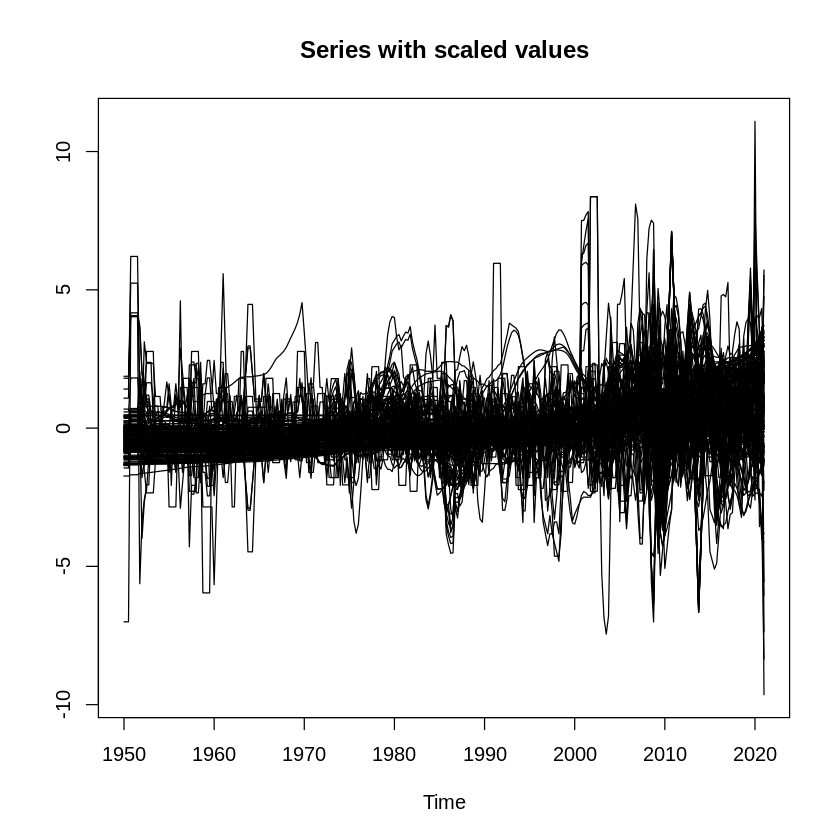

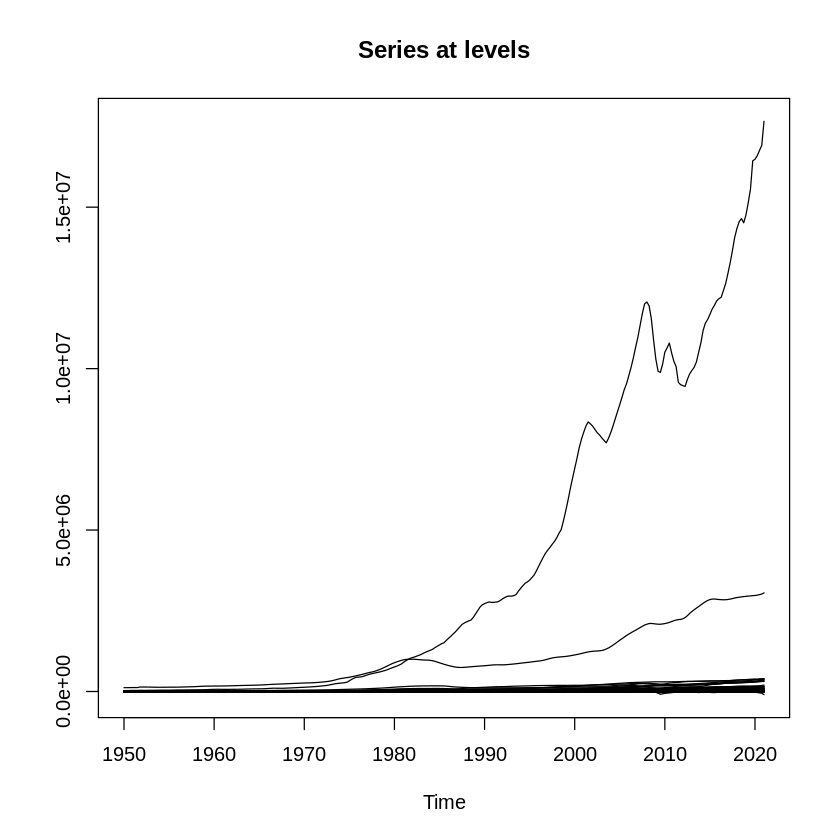

In [177]:
df_cleaned <- new_df.cleaned
total_na <- sum(is.na(df_cleaned))
print(paste0("Once the filling of missing values is completed, the number of NAs is: ", total_na))

# Get the indices of elements containing '4quarters'
indices <- grep("4quarters", colnames(df_cleaned))

# Print the matched words
df_selected <- ts(df_cleaned[indices], start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])), frequency=4)

df_selected |> head()

ts.plot(scale(df_selected), main="Series with scaled values")
ts.plot(df_selected, main="Series at levels")

### Presentation of the target variable
The following shows the variables included in the dataset. Among these, the selected target variable for this experiment is *Private_Depository_Institutions*, which corresponds to an index generated to measure farmers' inventories held by the private sector. This variable, like the others, has been transformed into a moving average of four quarters, thereby smoothing the variable. The personal objective of this exercise is to predict the variable at levels using the other variables reduced to their three main components.

#### Decomposition
The following presents an additive decomposition of the variable to be predicted.


In [180]:
colnames(df_selected) |> data.frame() |> head()

,colnames.df_selected.
,<chr>
1,All_Sectors__Farm_Mortgages__Asset__Revaluation4quarters
2,All_Sectors__Farm_Mortgages__Asset__Transactions4quarters
3,All_Sectors__Total_Commercial_and_Farm_Mortgages__Asset__Revaluation4quarters
4,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters
5,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Transactions4quarters
6,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Level4quarters


In [182]:
target_variable <- "Private_Depository_Institutions__Farm_Mortgages__Asset__Transactions4quarters"


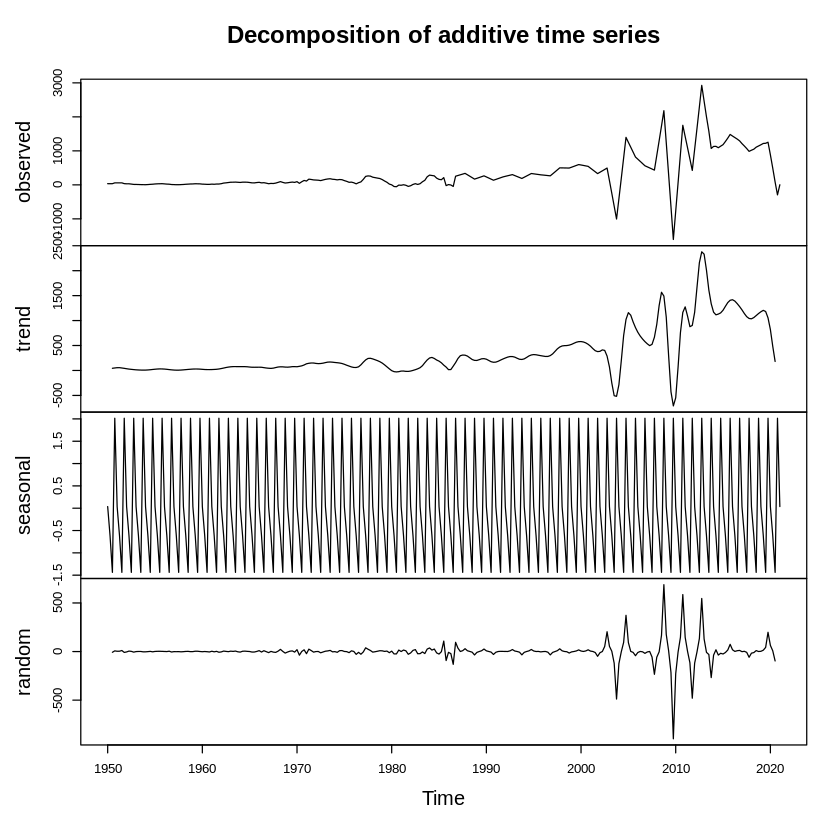

In [183]:
plot(decompose(df_selected[,target_variable]))


# Dimensionality Reduction
The following performs various correlation analyses with the aim of obtaining a more limited set of variables.


In [184]:
Correlation_Matrix <-  as.data.frame(cor(df_selected))
Correlation_Matrix |> head()

Warning message in cor(df_selected):
“the standard deviation is zero”


,All_Sectors__Farm_Mortgages__Asset__Revaluation4quarters,All_Sectors__Farm_Mortgages__Asset__Transactions4quarters,All_Sectors__Total_Commercial_and_Farm_Mortgages__Asset__Revaluation4quarters,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters,Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Transactions4quarters,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Level4quarters,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Revaluation4quarters,Corporate_Farm_Business__Farm_Credit_System_Loans__Liability__Transactions4quarters,Corporate_Farm_Business__Farm_Mortgages__Liability__Revaluation4quarters,Corporate_Farm_Business__Gross_Investment__Transactions4quarters,⋯,Nonfinancial_Noncorporate_Business__Total_Mortgages__Excluding_Noncorporate_Farms__Liability__Revaluation4quarters,Other_Financial_Corporations_and_Insurance_Companies_and_Pension_Funds__Farm_Mortgages__Asset__Level4quarters,Other_Financial_Corporations_and_Insurance_Companies_and_Pension_Funds__Farm_Mortgages__Asset__Revaluation4quarters,Private_Depository_Institutions__Farm_Mortgages__Asset__Revaluation4quarters,Private_Depository_Institutions__Farm_Mortgages__Asset__Transactions4quarters,Private_Depository_Institutions__One_to_Four_Family_Residential_Mortgages__Including_Farm_Houses__Asset__Revaluation4quarters,U_S__Chartered_Depository_Institutions__Depository_Institution_Loans_N_E_C__to_Farm_Business__Asset__Level4quarters,U_S__Chartered_Depository_Institutions__Depository_Institution_Loans_N_E_C__to_Farm_Business__Asset__Revaluation4quarters,U_S__Chartered_Depository_Institutions__Depository_Institution_Loans_N_E_C__to_Farm_Business__Asset__Transactions4quarters,U_S__Chartered_Depository_Institutions__Farm_Mortgages__Asset__USDA___Transactions4quarters
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
All_Sectors__Farm_Mortgages__Asset__Revaluation4quarters,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
All_Sectors__Farm_Mortgages__Asset__Transactions4quarters,NA,1.00000000,NA,0.03020820,0.03410456,0.64377483,-0.08521867,0.230524935,-0.03053926,0.415798973,⋯,NA,0.61022621,NA,NA,0.4735208,NA,0.53326945,NA,0.28142567,0.4746847
All_Sectors__Total_Commercial_and_Farm_Mortgages__Asset__Revaluation4quarters,NA,NA,1,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Revaluation4quarters,NA,0.03020820,NA,1.00000000,-0.01289885,0.03336339,0.08833602,0.006748008,0.24021213,-0.003182064,⋯,NA,0.02749297,NA,NA,-0.1015893,NA,-0.02606251,NA,-0.03282492,-0.1017450
Corporate_Farm_Business__Checkable_Deposits_and_Currency__Asset__Transactions4quarters,NA,0.03410456,NA,-0.01289885,1.00000000,0.08039740,0.03046983,0.218965378,-0.02540162,0.420822865,⋯,NA,0.09907154,NA,NA,0.1935049,NA,0.10312668,NA,-0.15152155,0.1965010
Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Level4quarters,NA,0.64377483,NA,0.03336339,0.08039740,1.00000000,-0.01438439,0.439442806,-0.11532479,0.833406169,⋯,NA,0.94707569,NA,NA,0.6898060,NA,0.92396969,NA,0.07170218,0.6904897


### Variable Selection
The variables that are correlated by more than 40% with the target variable are selected.


In [185]:
Correlation_Matrix <- Correlation_Matrix |>
  filter(!is.na(!!sym(target_variable))) |>
  filter(abs(!!sym(target_variable)) >= .40 & abs(!!sym(target_variable)) != 1)

matriz <- as.data.frame(Correlation_Matrix[, target_variable], row.names = rownames(Correlation_Matrix))
colnames(matriz) <- paste0(target_variable)

print(matriz)

                                                                                                                                                                                         Private_Depository_Institutions__Farm_Mortgages__Asset__Transactions4quarters
All_Sectors__Farm_Mortgages__Asset__Transactions4quarters                                                                                                                                                                                                    0.4735208
Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Level4quarters                                                                                                                                                                      0.6898060
Corporate_Farm_Business__Gross_Investment__Transactions4quarters                                                                                                                                                   

### Generation of the Target Variable and Its Predictor Variables
In this stage, we select the vector to predict and the matrix of predictors.

In [186]:
target <- df_selected[,target_variable]
xreg <- df_selected[,rownames(Correlation_Matrix)]

target |> head()
xreg |> head()

,Qtr1,Qtr2,Qtr3,Qtr4
1950,35,35,35,59
1951,59,59,,


,All_Sectors__Farm_Mortgages__Asset__Transactions4quarters,Corporate_Farm_Business__Depository_Institution_Loans_N_E_C___Liability__Level4quarters,Corporate_Farm_Business__Gross_Investment__Transactions4quarters,Corporate_Farm_Business__Gross_Saving__Transactions4quarters,Corporate_Farm_Business__Loans__Liability__Level4quarters,Corporate_Farm_Business__Net_Worth__Revaluation4quarters,Corporate_Farm_Business__Nonfinancial_Assets__Revaluation4quarters,Corporate_Farm_Business__Nonresidential_Equipment__Current_Cost_Basis__Level4quarters,Corporate_Farm_Business__Nonresidential_Equipment__Current_Cost_Basis__Transactions4quarters,Corporate_Farm_Business__Nonresidential_Structures__Current_Cost_Basis__Level4quarters,Corporate_Farm_Business__Nonresidential_Structures__Current_Cost_Basis__Revaluation4quarters,Corporate_Farm_Business__Other_Loans_and_Advances__Liability__Level4quarters,Corporate_Farm_Business__Real_Estate__Revaluation4quarters,Corporate_Farm_Business__Total_Assets__Revaluation4quarters,Corporate_Farm_Business__Total_Liabilities__Transactions4quarters,Corporate_Farm_Business__Total_Miscellaneous_Assets__Level4quarters,Domestic_Financial_Sectors__Farm_Mortgages__Asset__Transactions4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Consumption_of_Fixed_Capital__Nonresidential_Structures__Current_Cost_Basis__Transactions4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Gross_Fixed_Investment__Nonresidential_Equipment__Transactions4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Gross_Fixed_Investment__Nonresidential_Structures__Transactions4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Gross_Investment__Transactions4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Land_at_Market_Value__Revaluation4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Loans__Liability__Transactions4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Net_Worth__Revaluation4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Nonfinancial_Assets__Level4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Nonfinancial_Assets__Revaluation4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Nonresidential_Structures__Current_Cost_Basis__Revaluation4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Short_Term_Loans__Liability__Level4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Total_Miscellaneous_Assets__Level4quarters,Farm_Business__Included_in_Nonfinancial_Corporate_and_Noncorporate_Business_Sectors___Total_Nonreal_Estate_Loans__Liability__Level4quarters,Government_Sponsored_Enterprises__Checkable_Deposits_and_Currency_Held_by_Farm_Credit_System__Asset__Level4quarters,Government_Sponsored_Enterprises__Corporate_Equities_of_Farm_Credit_System__Liability__Level4quarters,Government_Sponsored_Enterprises__GSE_Issues_of_Farm_Credit_System__Liability__Level4quarters,Government_Sponsored_Enterprises__Premises_and_Equipment_of_Farm_Credit_System__Book_Value__Level4quarters,Government_Sponsored_Enterprises__Total_Financial_Assets_Held_by_Farm_Credit_System__Level4quarters,Government_Sponsored_Enterprises__Total_Liabilities_of_Farm_Credit_System__Level4quarters,Government_Sponsored_Enterprises__Total_Liabilities_of_Farm_Credit_System__Transactions4quarters,Government_Sponsored_Enterprises__Total_Miscellaneous_Liabilities_of_Farm_Credit_System__Level4quarters,Government_Sponsored_Enterprises__Unidentified_Miscellaneous_Assets_Held_by_Farm_Credit_System__Level4quarters,Government_Sponsored_Enterprises__Unidentified_Miscellaneo

### Dimensionality Reduction
The step is to convert XREG into a matrix, which is a dataset with 9 columns. Once converted into a matrix, the extraction of the principal components is generated. From these components, the first 3 are selected to be used in the different models explored.


In [187]:
ts_matrix <- embed(xreg)

pca <- prcomp(ts_matrix)

xreg_reduced <- scale(pca$x[,1:3])
xreg_reduced |> head()

PC1,PC2,PC3
-0.8397611,-0.7699255,-1.0167330
-0.8397611,-0.7699255,-1.0167330
-0.8397611,-0.7699255,-1.0167330
-0.8386960,-0.7636326,-0.9884623
-0.8386960,-0.7636326,-0.9884623
-0.8386960,-0.7636326,-0.9884623


#Model Training
As a first step, the initial univariate models are generated, which will later be presented alongside the multivariate models (only the ARIMA model will be presented).

### Modelos univariados

In [188]:
# Load the necessary library
library(forecast)

# Function to fit and forecast with multiple models
multi_model_forecast <- function(target) {

  # Fit ARIMA model
  fit.arima <- auto.arima(target, stepwise=F, lambda=T, parallel = T, num.cores = 4)

  # Fit BAGGED model
  fit.baggedModel <- baggedModel(target, bootstrapped_series = bld.mbb.bootstrap(target, 100))

  # Fit NNETAR model
  fit.nnetar <- nnetar(target, parallel = T, num.cores = 4)

  # Produce forecasts for ARIMA
  forecasts.arima <- forecast(fit.arima, h = 100, level = c(16, 68))$mean[1:100]

  # Produce forecasts for BAGGED
  forecasts.baggedModel <- forecast(fit.baggedModel, h = 100, level = c(16, 68))$mean[1:100]

  # Produce forecasts for NNETAR
  forecasts.nnetar <- forecast(fit.nnetar, h = 100, level = c(16, 68))$mean[1:100]

  # Return list of forecasts
  return(list(arima = forecasts.arima, nnetar = forecasts.nnetar,baggedModel = forecasts.baggedModel))
}

results <- multi_model_forecast(target)

# Data Division in Time Series

When working with time series, it is common to split the data into two sets:

* Training set
* Validation set (also known as backtesting)

The idea is to train your model on one part of the data (the training set) and then test its performance on an unseen portion of the data (the validation set).


## Rolling Window Function Generation


In [189]:
predicciones_rolling_auto = function(window,
                                     h, # horizonte predicción
                                     serie,
                                     frequency) {
  library(forecast)
  predicciones=NULL;
  cortar= length(serie)-window
  rolling=cortar:length(serie)
  print("Starting Process")
  for( i in rolling){
    x=NULL;
    x=ts(serie[1:i],frequency=frequency);
    predicted=forecast(auto.arima(x), h)[["mean"]];
    predicciones=append(predicciones,predicted);
    # Printing Progress
    ###print(paste0("Progress: ",format(((i+1-rolling[1])/(length(rolling)))*100),"%"),nsmall=2)
  }
  date=data.frame(Fecha=(format(index(serie)[which(serie[rolling[2]]==serie)],nsmall=2)));
  date=data.frame(c(strsplit(date$Fecha,"." , fixed = TRUE)));
  date[2,]=paste0(0,".",date[2,]);
  start.testing.hat=c(as.numeric(date[1,]),ifelse((round(as.numeric(date[2,])*12)+1)<10,
                                                  paste0(0, (round(as.numeric(date[2,])*12)+1)),
                                                  round(as.numeric(date[2,])*12)));
  start.testing=c(as.numeric(date[1,]),ifelse(round(as.numeric(date[2,])*12)<10,
                                              paste0(0, round(as.numeric(date[2,])*12)),
                                              round(as.numeric(date[2,])*12)));
  y_hat=ts(predicciones,start = start.testing.hat,frequency=frequency);
  y=ts(serie[rolling[1]:rolling[length(rolling)]],start = start.testing,frequency=frequency);
  error.puntual=y_hat/y-1;
  error.cum=ts(cumsum(error.puntual),start = start.testing.hat,frequency=frequency);
  # Saving results
  ts.predicciones<<-cbind(y_hat,
                          y,
                          error.puntual,
                          error.cum)
}

# Generating predictions for a horizon of 1 to see how the univariate model fits.


In [190]:
# ARIMA auto
prediccion=predicciones_rolling_auto(
  window = 80,
  h=1,
  serie = target,
  frequency = 4)

[1] "Starting Process"


### Graph of the rolling window predicting for 1 period

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


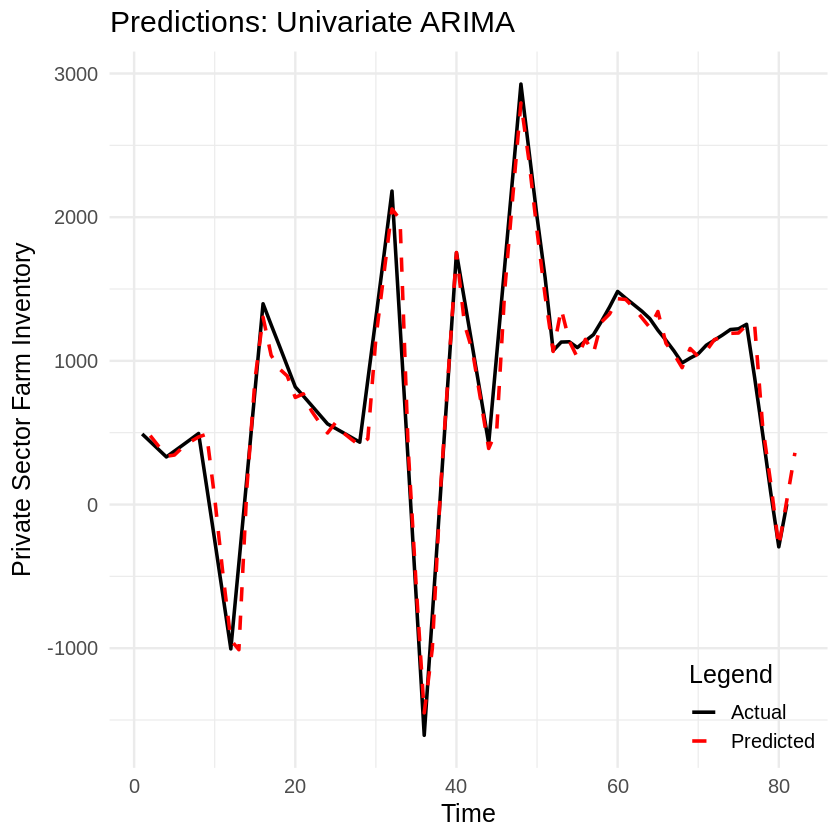

In [191]:
# Create a data frame for ggplot
prediccion_df <- data.frame(
  Time = seq_along(prediccion[,"y"]),
  Actual = prediccion[,"y"],
  Predicted = prediccion[,"y_hat"]
)

# Plot using ggplot2
ggplot2::ggplot(prediccion_df, ggplot2::aes(x = Time)) +
  ggplot2::geom_line(ggplot2::aes(y = Actual, color = "Actual"), linewidth = 1) +
  ggplot2::geom_line(ggplot2::aes(y = Predicted, color = "Predicted"), linetype = "dashed", linewidth = 1) +
  ggplot2::labs(
    title = "Predictions: Univariate ARIMA",
    y = "Private Sector Farm Inventory",
    color = "Legend"
  ) +
  ggplot2::scale_y_continuous(limits = c(min(c(prediccion[,"y"], prediccion[,"y_hat"]), na.rm = TRUE),
                                          max(c(prediccion[,"y"], prediccion[,"y_hat"]), na.rm = TRUE))) +
  ggplot2::theme_minimal(base_size = 15) +
  ggplot2::theme(legend.position = c(1, 0),   # Positioning legend at bottom right
                 legend.justification = c(1, 0)) +  # Adjust justification
  ggplot2::scale_color_manual(values = c("Actual" = "black", "Predicted" = "red"))

## Validation
Generation of the matrix to validate the forecasts over 4 instances. The first 100 instances will be omitted in the validation, and it will only be performed at the end as future predictions.

The idea is to test different models for their predictive capacity over 4 instances, where the sample acquires innovations and generates predictions that will later be compared to the actual outcomes. This way, we can construct 2 metrics to measure accuracy: one is MASE (Mean Absolute Scaled Error) and the other is MAPE (Mean Absolute Percentage Error). The first compares against a naive model, with a value less than 1 indicating better predictive capacity than a naive model. Regarding MAPE, it will allow us to know the average absolute error value, which indicates the proportion by which the model errs.

La siguiente gráfica busca expresar la metodología a utilizar.
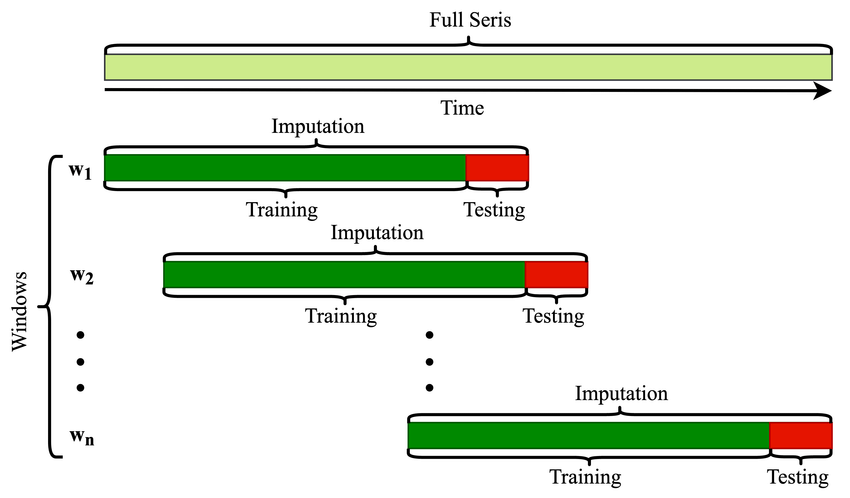


In [192]:
window=78
Compare=c(target[(length(target)-(window+3)):length(target)])
Matriz=cbind(Compare,
             lead(Compare),
             lead(Compare,2),
             lead(Compare,3),
             lead(Compare,4))

Matriz=Matriz[1:window,]


Generating predictions for the validation of the ARIMA model.

In [193]:
test_arima=matrix(0,ncol=4,nrow=window);
for( i in 1:window){
      y=NULL
      y=ts(target[1:(length(target)-82+i)],frequency=4)
      predicted=matrix(c(forecast(auto.arima(y), 4)[["mean"]][1:4]),ncol=4);
      test_arima[i,]=predicted;
}

### Multivariate Models


ARIMAX or SARIMAX, it all depends on the seasonal component; if it has one, it will be called SARIMAX

In [194]:
test_arimax = matrix(0, ncol=4, nrow=window)
for (i in 1:window) {
    y = NULL
    x = NULL
    y = ts(target[1:(length(target) - 82 + i)], frequency=4)
    x = ts(xreg_reduced[1:(length(target) - 82 + i),], frequency=4)
    predicted = matrix(c(forecast(auto.arima(y, xreg=x), xreg=x, 4)[["mean"]][1:4]), ncol=4)
    test_arimax[i,] = predicted
}

In [195]:
# Generación del set de datos
data_blended.ts <- ts(cbind(target, xreg_reduced), start=c(1950, 01), frequency=4)

#### GARCH Model
##### It is not finding a solution; model omitted
The GARCH model (Generalized Autoregressive Conditional Heteroskedasticity Models) is a statistical tool used to predict future volatilities based on time series data from the past.
The variable to be predicted will feed the model without being transformed, meaning it will be used at levels. The 3 principal components of the 8 selected series are used as predictor variables.

In [197]:
# Load the necessary library
library(fGarch)

# Define your data here
#data <- data_blended.ts

# Fit a GARCH(1,1) model as a starting point
#fit.garch_100<- suppressWarnings(garchFit(target ~ garch(1, 1), data = data))

# Check the summary of the fitted model
#summary(fit.garch.100)

# Produce forecasts
#forecasts.garch_100 <- predict(fit.garch_100, n.ahead = 100)

#forecasts.garch_100 |> head()

In [113]:
#test_GARCH=matrix(0,ncol=4,nrow=window);
#for( i in 1:window){
#      x=NULL
#      x=ts(data_blended.ts[1:(length(target)-82+i),],frequency=4)
#      predicted=matrix(c(predict(suppressWarnings(garchFit(target ~ garch(1, 1), data = x, trace = FALSE)), n.ahead = 4)$meanForecast),ncol=4);
#      test_GARCH[i,]=predicted;
#}

In [198]:
install.packages("Metrics",dependencies = T)
library(Metrics)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



##### We plot the predictions of 100 future instances
The following graph shows the predictions for 100 instances from the GARCH model generated by the target variable and the 3 principal components of the predictor variables.
mase(forecasts.garch)

In [199]:
# Combine original data and forecasts into a single data frame
#combined_data <- data.frame(
#  Time = seq_along(c(data[,"target"], forecasts.garch_100$meanForecast)),
#  Value = c(data[,"target"], forecasts.garch_100$meanForecast),
#  Type = rep(c("Original Data", "GARCH Forecasts"),
#             times = c(nrow(data), length(forecasts.garch_100$meanForecast)))
#)

# Plot with ggplot2
#ggplot(combined_data, aes(x = Time, y = Value, color = Type)) +
#  geom_line(size = 1) +                          # Line plot
#  labs(title = "Original Data and GARCH Forecasts",
#       x = "Time",
#       y = "Values") +
#  scale_color_manual(values = c("Original Data" = "blue", "GARCH Forecasts" = "red")) +  # Custom colors
#  theme_minimal() +                              # Clean theme
#  theme(legend.title = element_blank())         # Remove legend title

#### VAR Model
The VAR (Vector Autoregressive Model) is a type of statistical model that uses a time series of its own observations, their lags, and regressors to predict future values.
No interpretation of the obtained parameters will be made. It is recommended to conduct a more in-depth analysis of these models to see if they are truly relevant. In this exercise, the goal is only to apply the model and generate predictions for 100 future instances.

AIC(n) 
     4

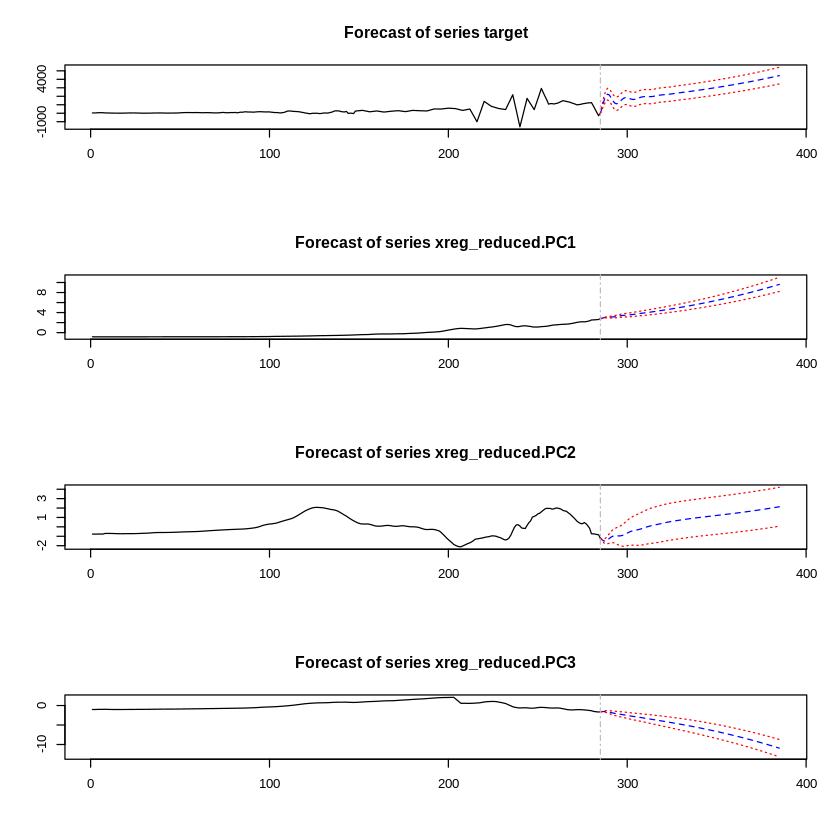

In [200]:
# Fit a VAR model
parameters.var.selected <- VARselect(data_blended.ts, lag.max = 4, type = c("const", "trend", "both", "none"))
fit.var_100 <- VAR(data_blended.ts, p = parameters.var.selected$selection[1]) # We will use the AIC(n) metric: 5
parameters.var.selected$selection[1]

# Forecast next 10 steps
forecasts.var_100 <- predict(fit.var_100, n.ahead = 100)

plot(forecasts.var_100)

In [201]:
test_VAR = matrix(0, ncol = 4, nrow = window)
for (i in 1:window) {
    x = NULL
    x = ts(data_blended.ts[1:(length(target) - 82 + i), ], frequency = 4)
    parameters.var.selected <- VARselect(x, lag.max = 4, type = c("const", "trend", "both", "none"))
    fit.var <- VAR(x, p = parameters.var.selected$selection[1]) # We will use the AIC(n) metric: 5

    predicted = matrix(c(predict(fit.var, n.ahead = 4)$fcst$target[, 1]), ncol = 4)
    test_VAR[i, ] = predicted
}


# Generation of the dataset for the last model

In [204]:
data_blended.ts <- ts(cbind(c(target,rep(NA,100)),
    rbind(xreg_reduced,cbind(PC1=rep(NA,100),PC2=rep(NA,100),	PC3=rep(NA,100)))),
    start=c(1950,1),frequency=4)

## Multivariate ARIMA Model
ARIMA models, in their SARIMAX version, which include seasonality and exogenous variables, are very popular. One way to apply this type of model is through the auto.arima() function from the forecast library, which allows loading regressor variables within the XREG argument of its function. It is important to highlight that the variable is entered at levels in the model, and predictions will also be made at levels concerning its regressors. These are the 3 main components that were used in the previous model.


In [205]:
# Define the indices to exclude from target and exogenous regressors
exclusion_indices <- -c((length(target)+1):(length(target)+100))

# Create a time series for the exogenous regressors, excluding some observations
X <- ts(data_blended.ts[exclusion_indices, -1],
        start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
        frequency=4)

# Create a time series for all observations of the exogenous regressors
X.2 <- ts(data_blended.ts[, -1],
          start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
          frequency=4)

# Fit an ARIMA model to the time series data (excluding some observations)
# with additional regressors included in the model.
# Then, generate forecasts for the fitted model using X.2 as xreg
forecast.sarimax <- suppressWarnings(forecast::forecast(
    forecast::auto.arima(ts(data_blended.ts[exclusion_indices, 1],
                            start=c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
                            frequency=4),
    xreg = X),
    xreg = X.2)$mean[1:100])

#Selection of the Best Model
The Mean Absolute Scaled Error (MASE) is a metric used in statistics to measure the accuracy of forecasting methods. It is calculated as:

```python
MASE = mean(abs(y - y_hat)) / mean(abs(y - lag(y)))
```

Where:
- `y` is the actual value,
- `y_hat` is the predicted value, and
- `lag(y)` is the previous value in the time series.

MASE scales the mean absolute error relative to the error of a naive forecasting method, which simply forecasts the next data point as the last observed value. A MASE less than 1 indicates that the forecasting model performs better than the naive method.

* **In-Sample**: The best model by predictive capability within the sample is the ARIMA, an autoregressive model.
* **Out-of-Sample or Validation**: The ARIMA model is the most effective for predictive capability across horizons of 1 to 4 quarters. However, this may vary depending on the characteristics of the dataset. For instance, if the data exhibits strong seasonal patterns, models such as SARIMAX may yield more accurate predictions. Alternatively, GARCH or VAR models might be more suitable depending on the specific nature of the time series being analyzed. Ultimately, the choice of model should align with the distinct features of the series in question.

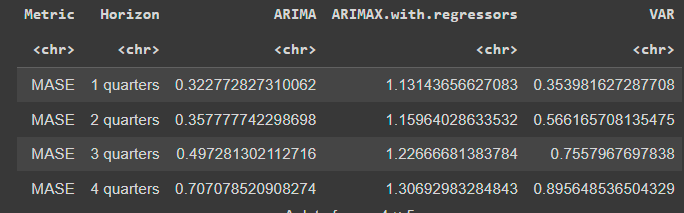


## In sample
The ARIMA model has greater predictive capacity using the MASE metric

In [206]:
# @title
# Fit a SARIMAX model using auto.arima from the forecast package
mod.sarimax <- forecast::auto.arima(
  y = ts(data_blended.ts[exclusion_indices, 1],
         start = c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
         frequency = 4),
  xreg = X
)

# Fit an ARIMA model without exogenous variables
mod.arima <- forecast::auto.arima(
  y = ts(data_blended.ts[exclusion_indices, 1],
         start = c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
         frequency = 4)
)

# Print Mean Absolute Scaled Error (MASE) for ARIMA model
print(paste0("ARIMA MASE: ", mase(mod.arima$fitted, mod.sarimax$x)))

# Print Mean Absolute Scaled Error (MASE) for SARIMAX model
print(paste0("SARIMAX MASE: ", mase(mod.sarimax$fitted, mod.sarimax$x)))

# Print Mean Absolute Scaled Error (MASE) for GARCH model
#print(paste0("GARCH MASE: ", mase(mod.sarimax$x + residuals(fit.garch_100), mod.sarimax$x)))

# Print Mean Absolute Scaled Error (MASE) for VAR model
print(paste0("VAR MASE: ", mase(imputeTS::na_ma(c(rep(NA, 4), fit.var_100$varresult$target$fitted.values)), mod.sarimax$x)))


[1] "ARIMA MASE: 0.332152700042027"
[1] "SARIMAX MASE: 0.370901331970909"
[1] "VAR MASE: 0.682045386940164"


## Generation of Final Tables

In [207]:
# @title
# Initialize an empty data frame for MAPE
MAPE = NULL

# Loop through 1 to 4 (representing quarters)
for (i in 1:4) {
  # Append MAPE results to the data frame
  MAPE = data.frame(rbind(MAPE, c(
    "Metric" = "MAPE",
    "Horizon" = paste0(i, " quarters"),
    "ARIMA" = mape(Matriz[, i], test_arima[, i]),
    "ARIMAX with regressors" = mape(Matriz[, i], test_arimax[, i]),
    "VAR" = mape(Matriz[, i], test_VAR[, i])#,
    #"GARCH" = mape(Matriz[, i], test_GARCH[, i])
  )))
}

# Initialize an empty data frame for MASE
MASE = NULL

# Loop through 1 to 4 (representing quarters)
for (i in 1:4) {
  # Append MASE results to the data frame
  MASE = data.frame(rbind(MASE, c(
    "Metric" = "MASE",
    "Horizon" = paste0(i, " quarters"),
    "ARIMA" = mase(Matriz[, i], test_arima[, i], step_size = 4),
    "ARIMAX with regressors" = mase(Matriz[, i], test_arimax[, i], step_size = 4),
    "VAR" = mase(Matriz[, i], test_VAR[, i], step_size = 4)#,
    #"GARCH" = mase(Matriz[, i], test_GARCH[, i], step_size = 4)
  )))
}


In [208]:
MASE
MAPE

Metric,Horizon,ARIMA,ARIMAX.with.regressors,VAR
<chr>,<chr>,<chr>,<chr>,<chr>
MASE,1 quarters,0.322772827310062,1.13143656627083,0.353981627287708
MASE,2 quarters,0.357777742298698,1.15964028633532,0.566165708135475
MASE,3 quarters,0.497281302112716,1.22666681383784,0.7557967697838
MASE,4 quarters,0.707078520908274,1.30692983284843,0.895648536504329


Metric,Horizon,ARIMA,ARIMAX.with.regressors,VAR
<chr>,<chr>,<chr>,<chr>,<chr>
MAPE,1 quarters,0.482622655873254,0.984211088735864,0.592716348027218
MAPE,2 quarters,0.522334550709646,0.957252390578011,0.823244247188812
MAPE,3 quarters,0.620814882209522,1.20682541030429,0.998978652150771
MAPE,4 quarters,0.946462946897482,1.06408275976214,1.28361542826157


# Prediction for 100 Instances
Next, we will generate forecasts over a horizon of 100 instances. Among the models evaluated, the ARIMA model stands out as the most effective for long-term predictions. Additionally, ARIMA models demonstrate superior predictive capability in the short term (less than 4 quarters) when assessed using the Mean Absolute Scaled Error (MASE) metric.

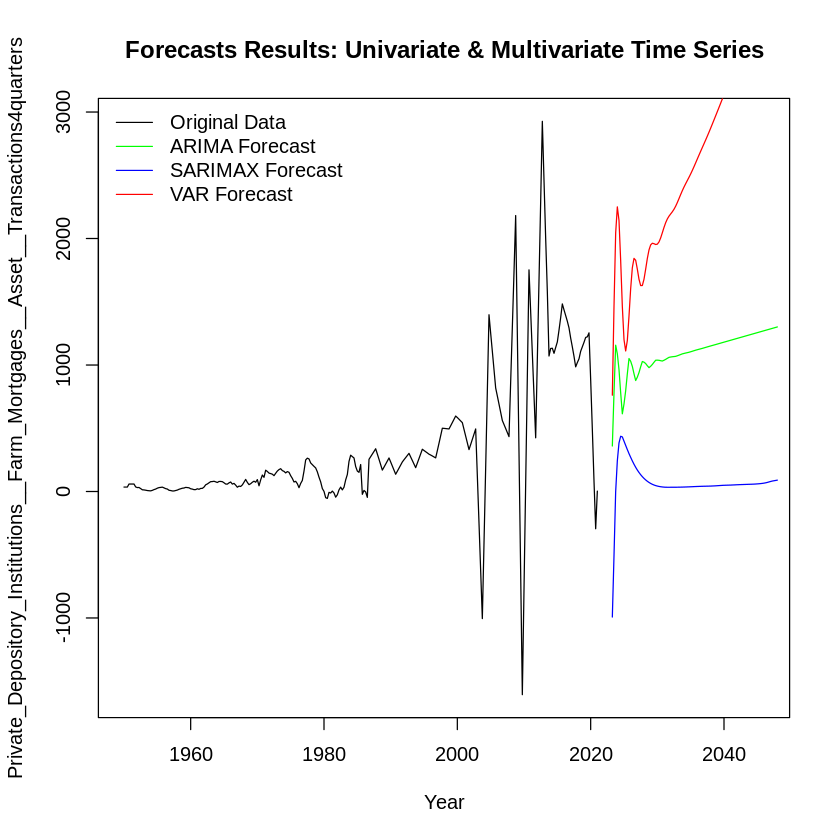

In [211]:
# @title
# Create a time series plot for the target variable
plot(ts(c(target, rep(NA, 100)),
         start = c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
         frequency = 4),
     main = "Forecasts Results: Univariate & Multivariate Time Series",
     ylab = target_variable,
     xlab = "Year", type = "l")

# Add ARIMA forecast line
lines(ts(c(rep(NA, 293), results$arima),
          start = c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
          frequency = 4), col = "green")

# Add ARIMAX forecast line
lines(ts(c(rep(NA, 293), forecast.sarimax),
          start = c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
          frequency = 4), col = "blue")

# Add GARCH forecast line
#lines(ts(c(rep(NA, 293), forecasts.garch_100$meanForecast),
#          start = c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
#          frequency = 4), col = "grey")

# Add VAR forecast line
lines(ts(c(rep(NA, 293), forecasts.var_100$fcst$target[, 1]),
          start = c(year(df_cleaned$date[1]), month(df_cleaned$date[1])),
          frequency = 4), col = "red")

# Add legend to the plot
legend("topleft",
       legend = c("Original Data", "ARIMA Forecast", "SARIMAX Forecast", #"GARCH Forecast",
       "VAR Forecast"),
       col = c("black", "green", "blue", #"grey",
        "red"),
       lty = c(1, 1, 1, #1,
       1),
       bty = "n")
